In [1]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import MultivariateNormal, Bernoulli
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import clear_output
import os

from sklearn.mixture import GaussianMixture as mix
from sklearn.decomposition import PCA

In [2]:
vae_fig_folder = "../report/figures/vae/"
cvae_fig_folder = "../report/figures/cvae/"
ppca_fig_folder = "../report/figures/ppca/"
gmm_fig_folder = "../report/figures/gmm/"
os.makedirs(os.path.dirname(vae_fig_folder), exist_ok=True)
os.makedirs(os.path.dirname(cvae_fig_folder), exist_ok=True)
os.makedirs(os.path.dirname(ppca_fig_folder), exist_ok=True)
os.makedirs(os.path.dirname(gmm_fig_folder), exist_ok=True)
os.makedirs("results/", exist_ok=True)

# Dataset

In [3]:
train_set = datasets.MNIST(
    root = '../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST(
    root = '../data', train=False, download = True, transform=transforms.ToTensor())
N_test = len(test_set)

In [4]:
cuda2 = True  # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
torch.manual_seed(1)  # args.seed
device = torch.device("cuda" if cuda2 else "cpu")  # args.cuda

In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {}  # args.cuda
batch_size2 = 128
# Get train and test data
train_loader = torch.utils.data.DataLoader(train_set,
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set,
    batch_size=batch_size2, shuffle=False, **kwargs)

In [6]:
N_comp = 6
fig_h = 6
seed = 17
#generator = torch.Generator()
#generator.manual_seed(seed)
#indices = torch.randperm(N_test, generator=generator)[:N_comp]
indices = torch.arange(0,N_comp)
mnist_test = list(test_loader)
test_sampled = mnist_test[0][0][indices]
test_img_sampled = test_sampled.reshape(-1, 28, 28)

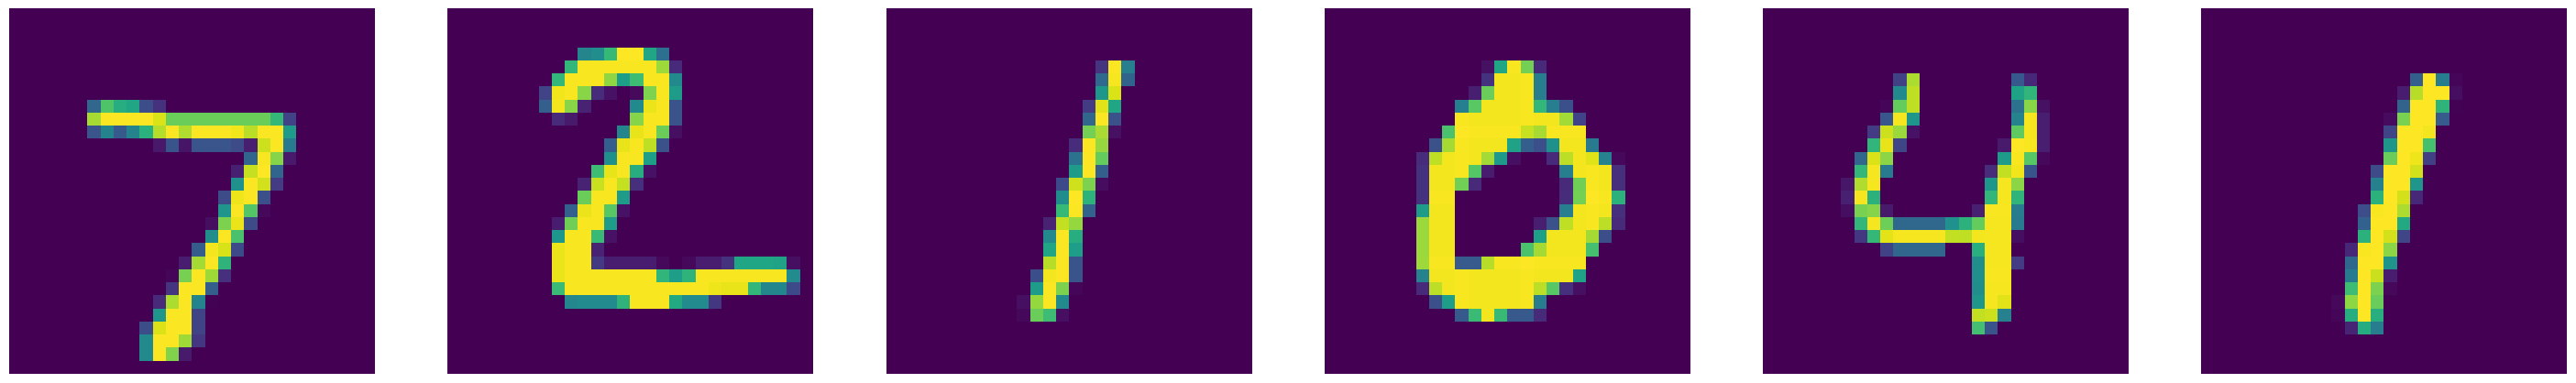

In [7]:
fig1, ax1 = plt.subplots(nrows=1, ncols=N_comp,
                         figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax1[j].axis("off")
    ax1[j].imshow(test_img_sampled[j])
plt.savefig(ppca_fig_folder + "real.pdf", bbox_inches="tight", facecolor="w")

# VAE

In [8]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2)  # Latent space of 2D
        self.fc22 = nn.Linear(100, 2)  # Latent space of 2D
        self.fc3 = nn.Linear(2, 100)  # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        temp = self.decode(z).view(-1, 1, 28, 28)
        return temp, mu, logvar


In [9]:
# Define CVAE model
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.fc1a = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        W, H = 7, 7
        self.fc21 = nn.Linear(32 * W * H, 2)
        self.fc22 = nn.Linear(32 * W * H, 2)
        self.fc3 = nn.Linear(2, 32 * W * H)
        self.fc3a = nn.ConvTranspose2d(
           32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.fc4 = nn.ConvTranspose2d(
            16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        h2 = h2.view(-1, 7 * 7 * 32)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = h3.view(-1, 32, 7, 7)
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
def conv_dims(in_dim, padding, kernel_size, dilation, stride):
    return torch.floor((torch.tensor(in_dim + 2 * padding - dilation * (kernel_size -1) -1)/stride) + 1)

def conv_t_dims(in_dim, padding, kernel_size, dilation, stride, output_padding):
    return (in_dim -1) * stride - 2 * padding + dilation * (kernel_size -1) + output_padding + 1

In [11]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, l = 1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return BCE + l * KLD  # -ELBO if l = 1, if l = 0 then we have simply the log likelihood of x given z 

def train(model, optimizer, train_loader, epoch):
    # so that everything has gradients and we can do backprop and so on...
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()  # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, l = 1)
        loss.backward()  # calc gradients
        train_loss += loss.item()
        optimizer.step()  # backpropagation
    clear_output(wait=True)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(model, test_loader, mean = True, mse = False):
    model.eval()
    e_log_prob = 0
    elbo = 0
    mse_loss = 0
    with torch.no_grad():  # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            e_log_prob -= loss_function(recon_batch, data, mu, logvar, l = 0).item()
            elbo -= loss_function(recon_batch, data, mu, logvar, l = 1).item()
            mse_loss += torch.nn.functional.mse_loss(recon_batch, data, reduction = "sum").item()
    if mean :
        e_log_prob /= N_test
        mse_loss /= N_test * 784
        elbo /= N_test
    print('====> Test set ELBO: {:.8f}'.format(elbo))
    print('====> Test set expected log likelihood: {:.8f}'.format(e_log_prob))
    print('====> Test set mse loss: {:.8f}'.format(mse_loss))
    return e_log_prob, mse_loss, elbo


def model_train(model, optimizer, train_loader, test_loader, epochs):
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_loader, epoch)
        e_log_prob, mse_loss, elbo = test(model, test_loader, mean = True)
        with torch.no_grad():
            sample = torch.randn(64, 2).to(device)  # 20 -> 2
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')
    return e_log_prob, mse_loss, elbo

In [12]:
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

cvae_model = CVAE().to(device)
cvae_optimizer = optim.Adam(cvae_model.parameters(), lr=1e-3)
num_epochs = 25

In [13]:
log_prob_vae, mse_loss_vae, elbo_vae = model_train(
    vae_model, vae_optimizer, train_loader, test_loader, num_epochs)

====> Epoch: 2 Average loss: 163.1896


In [ ]:
log_prob_cvae, mse_loss_cvae, elbo_cvae = model_train(
    cvae_model, cvae_optimizer, train_loader, test_loader, num_epochs)


====> Epoch: 25 Average loss: 157.5978
====> Test set ELBO: -156.81758218
====> Test set expected log likelihood: -151.09105640
====> Test set mse loss: 0.04425412


## Qualitative results

###  basic VAE

In [ ]:
B = len(mnist_test)
results = torch.zeros((128*B, 2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))

    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k, :, :, :]
        an_img_flat = torch.flatten(an_img)
        mean_img = vae_model.encode(an_img_flat.to(device))[0]
        results[l] = mean_img
        l += 1
results = results[:l, :]
all_labels = all_labels[:l]


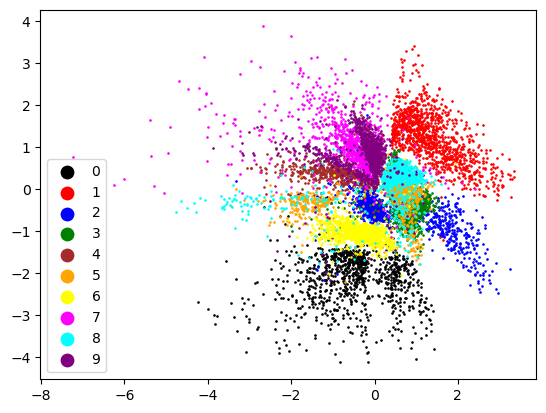

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:, 0]
scatter_y = results_for_plot[:, 1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown',
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize=(12, 12))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[g], label=int(g), s=0.8)
ax.legend(markerscale=10)
plt.savefig(vae_fig_folder + "clustering.pdf",
            bbox_inches="tight", facecolor="w")


c:\Users\Jacki\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


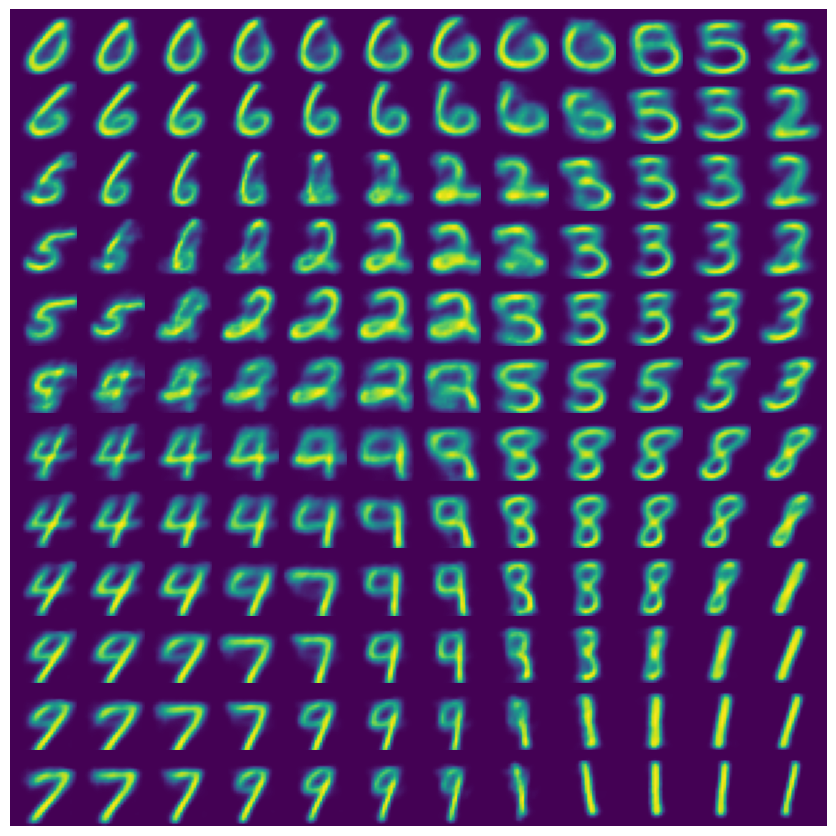

In [ ]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = vae_model.decode(torch.Tensor([y_val, x_val]).to(device))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().cpu().numpy()
        ax[i][j].imshow(plot_me)
        ax[i][j].axis("off")

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(vae_fig_folder + "interpolation.pdf",
            bbox_inches="tight", facecolor="w")


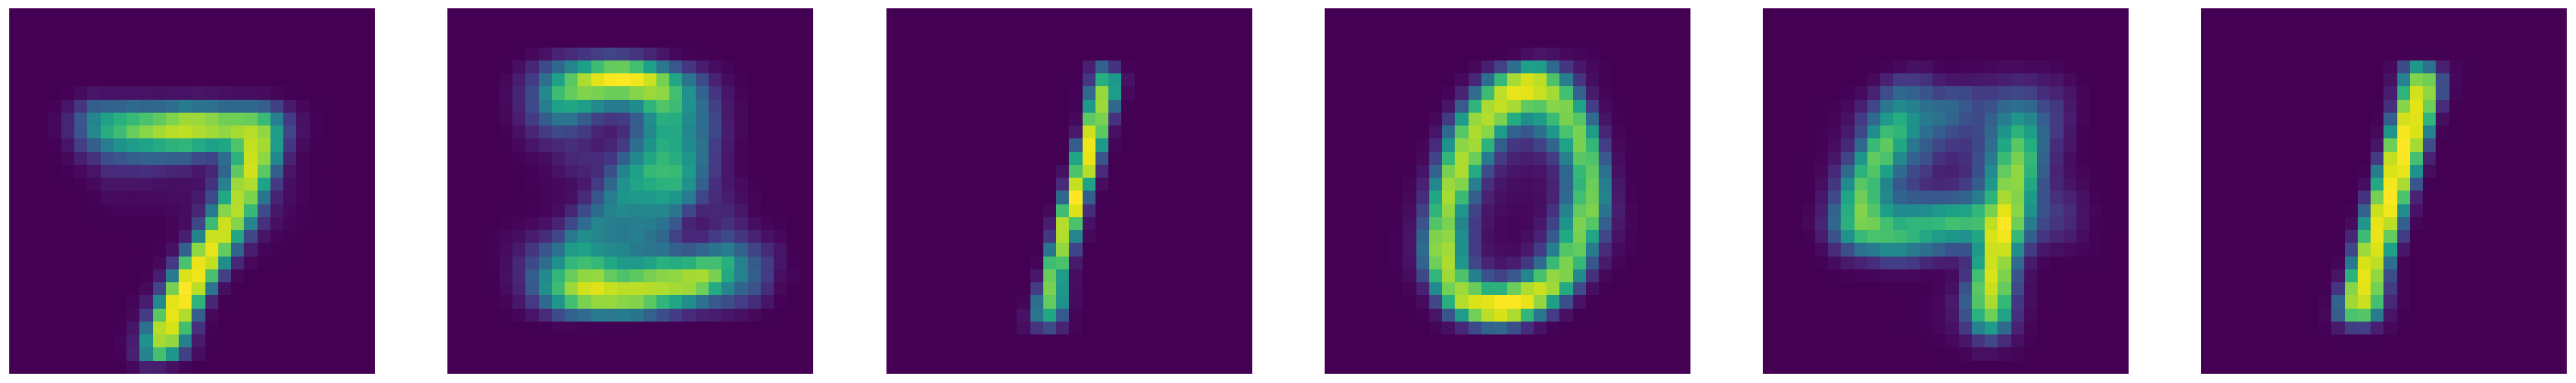

In [ ]:
recons_vae_sampled, _, _ = vae_model(test_sampled.to(device))
recons_vae_img_sampled = recons_vae_sampled.detach().cpu().reshape(-1, 28,28)
fig2, ax2 = plt.subplots(nrows=1, ncols=N_comp,
                         figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax2[j].axis("off")
    ax2[j].imshow(recons_vae_img_sampled[j])
plt.savefig(vae_fig_folder + "mean.pdf", bbox_inches="tight", facecolor="w")


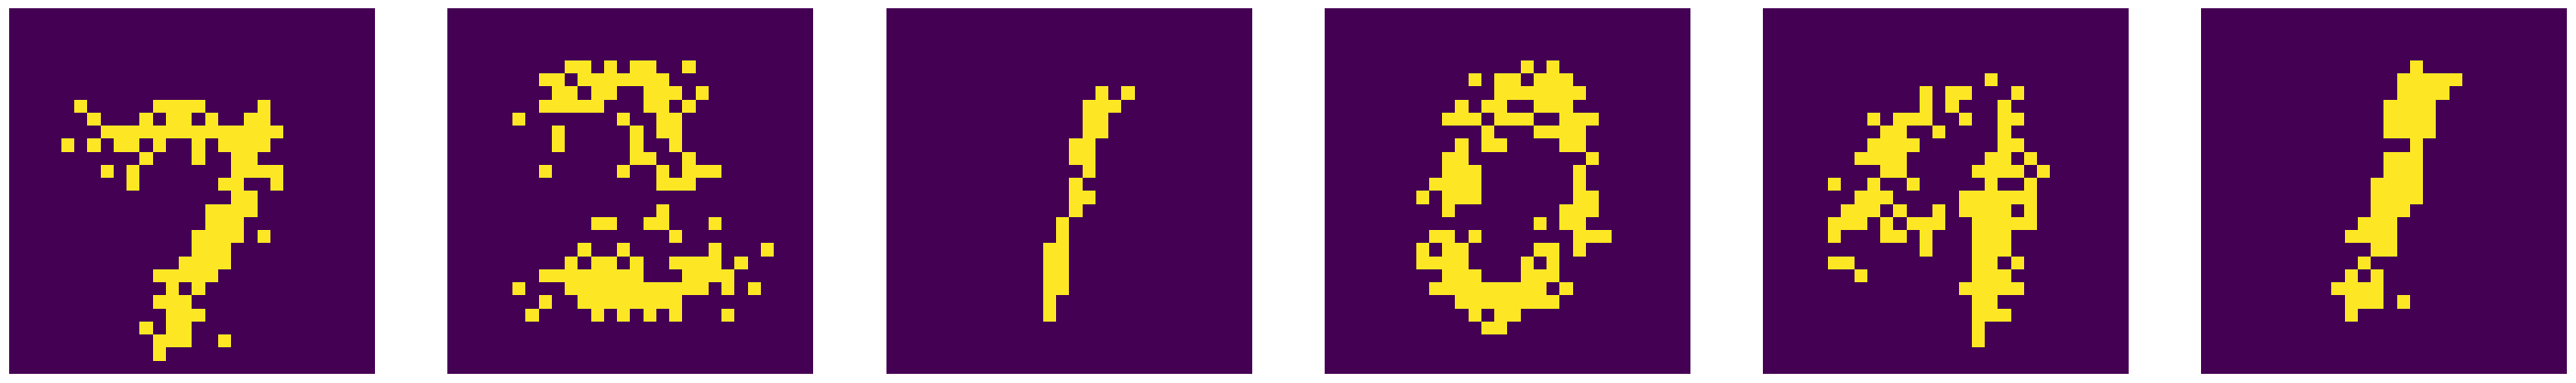

In [ ]:
bernoulli_vae = Bernoulli(recons_vae_img_sampled)
samples_vae = bernoulli_vae.sample()
fig3, ax3 = plt.subplots(nrows=1, ncols=N_comp,
                         figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax3[j].axis("off")
    ax3[j].imshow(samples_vae[j])
plt.savefig(vae_fig_folder + "sample.pdf", bbox_inches="tight", facecolor="w")

### CVAE

In [ ]:
B = len(mnist_test)
results = torch.zeros((128*B, 2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))

    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k, :, :, :]
        #an_img_flat = torch.flatten(an_img)
        mean_img = cvae_model.encode(an_img.to(device))[0]
        results[l] = mean_img
        l += 1
results = results[:l, :]
all_labels = all_labels[:l]


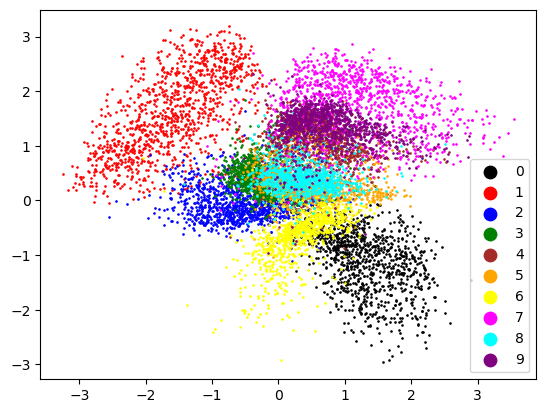

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:, 0]
scatter_y = results_for_plot[:, 1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown',
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize=(12, 12))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[g], label=int(g), s=0.8)
ax.legend(markerscale=10)
plt.savefig(cvae_fig_folder + "clustering.pdf",
            bbox_inches="tight", facecolor="w")


In [ ]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)


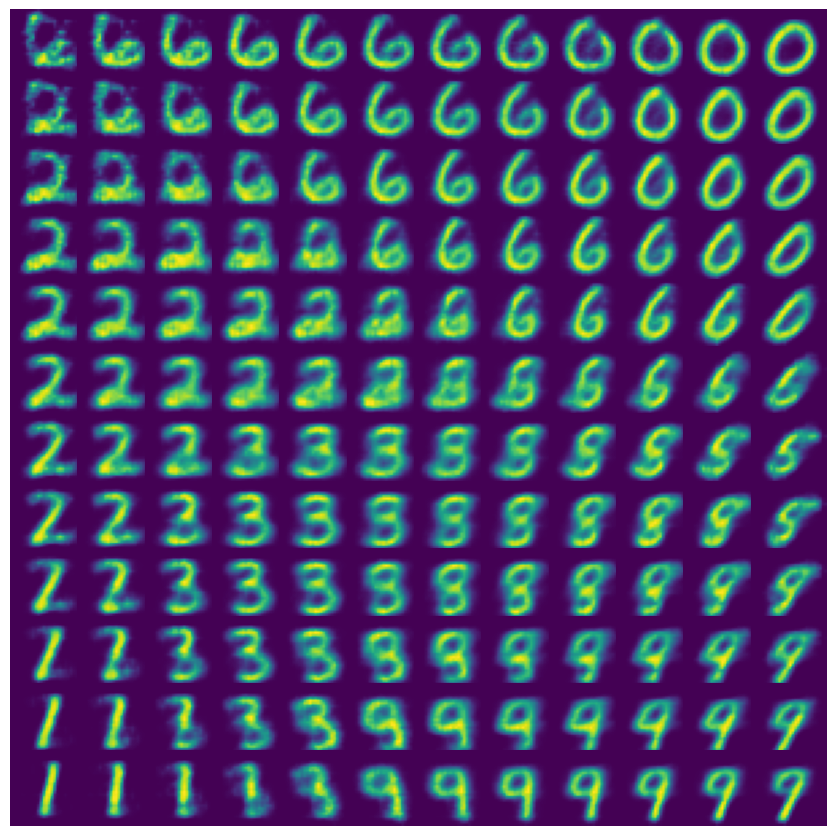

In [ ]:
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8),
                       sharex=True, sharey=True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i, j].item()
        y_val = gauss_y[i, j].item()
        im = cvae_model.decode(torch.Tensor([y_val, x_val]).to(device))
        im_plt = im.reshape((28, 28))
        plot_me = im_plt.detach().cpu().numpy()
        ax[i][j].imshow(plot_me)
        ax[i][j].axis("off")

slim = 0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(cvae_fig_folder + "interpolation.pdf",
            bbox_inches="tight", facecolor="w")

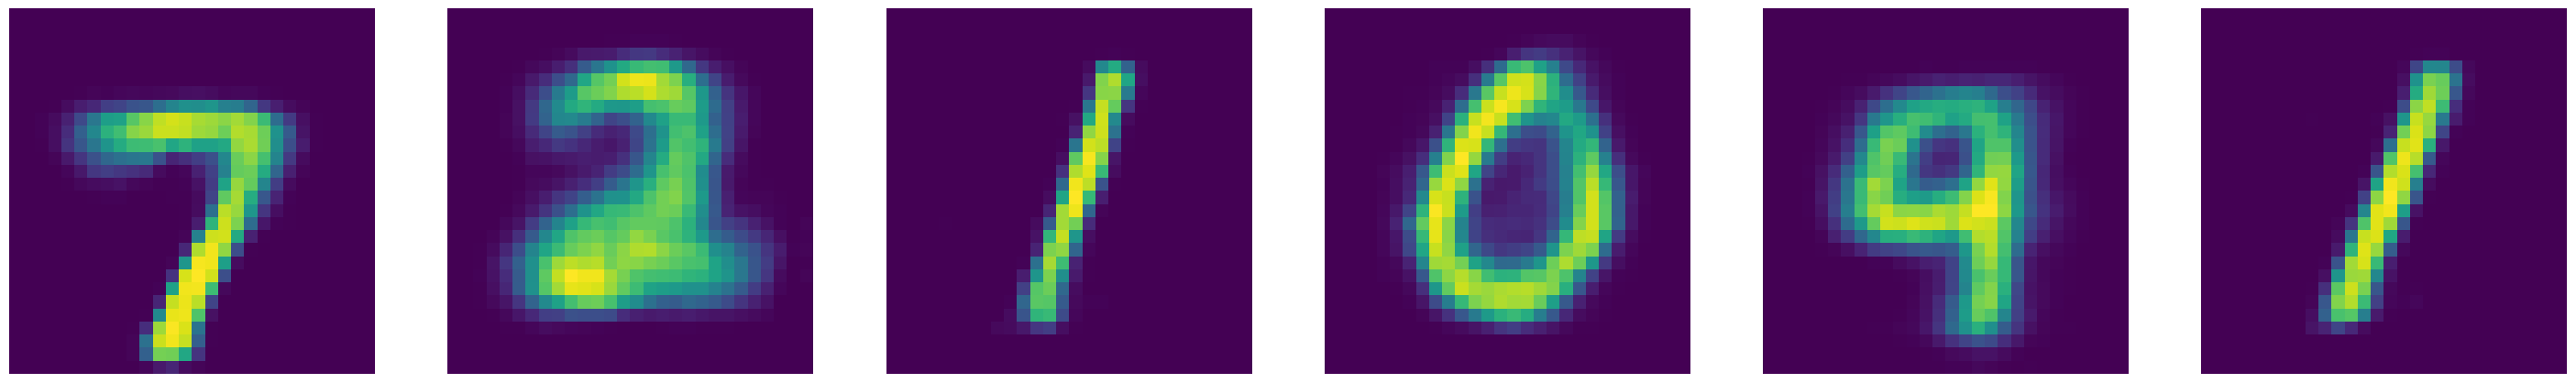

In [ ]:
recons_cvae_sampled, _, _ = cvae_model(test_sampled.to(device))
recons_cvae_img_sampled = recons_cvae_sampled.detach().cpu().reshape(-1, 28,28)
fig2, ax2 = plt.subplots(nrows=1, ncols=N_comp,
                         figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax2[j].axis("off")
    ax2[j].imshow(recons_cvae_img_sampled[j])
plt.savefig(cvae_fig_folder + "mean.pdf", bbox_inches="tight", facecolor="w")

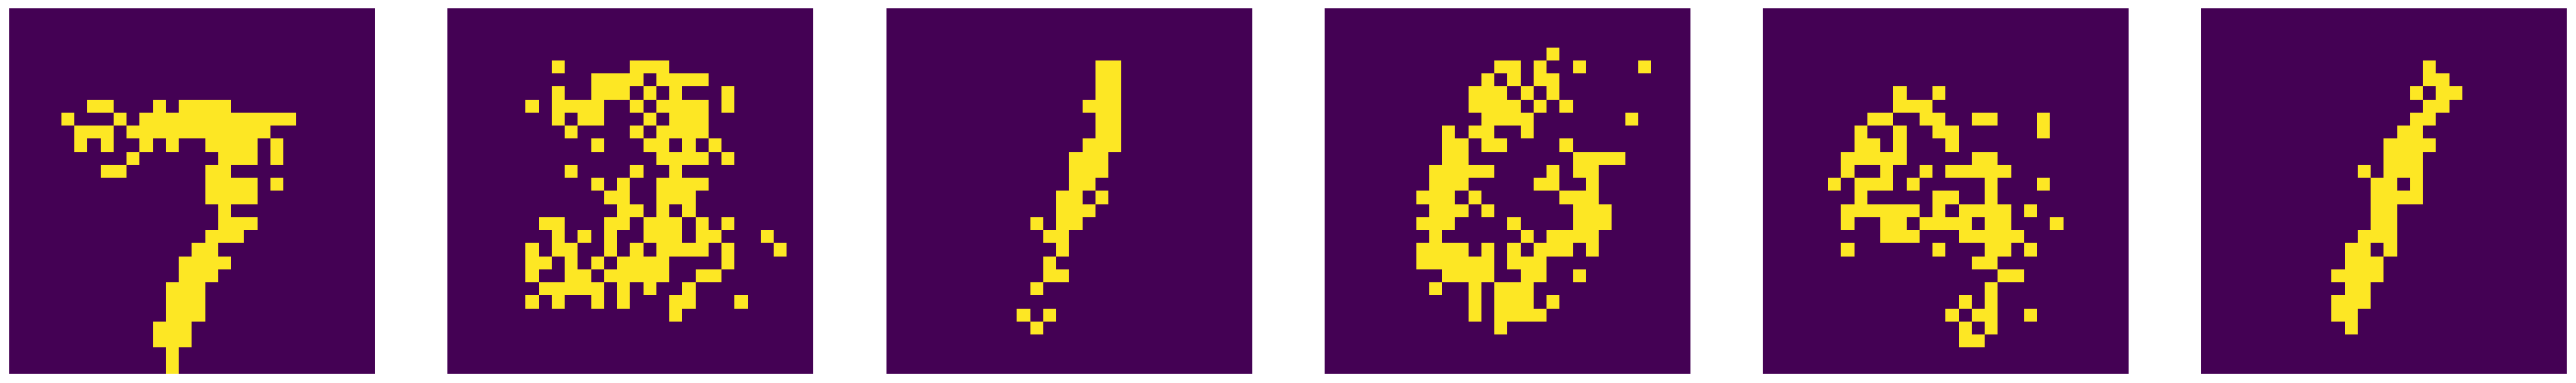

In [ ]:
bernoulli_cvae = Bernoulli(recons_cvae_img_sampled)
samples_cvae = bernoulli_cvae.sample()
fig3, ax3 = plt.subplots(nrows=1, ncols=N_comp,
                         figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax3[j].axis("off")
    ax3[j].imshow(samples_cvae[j])
plt.savefig(cvae_fig_folder + "sample.pdf", bbox_inches="tight", facecolor="w")


# PPCA

### Rather than estimating it directly using maximum likelihood, start by 
- estimating the data covariance matrix
- calculate the eigenvectors and eigenvalues
- to initialize 𝑊 (12.45)
- Then use eq 12.46 to calculate 𝜎

In [ ]:
train_vec = torch.reshape(train_set.data, (60000, 28*28))#.type(torch.double)
test_vec = torch.reshape(test_set.data, (10000, 28*28))#.type(torch.double)

In [ ]:
data_cov = torch.cov(train_vec.T)
data_eig = torch.linalg.eig(data_cov)
eig_vals = data_eig[0].real
eig_vecs = data_eig[1].real
#eig_vals = data_eig[0]
#eig_vecs = data_eig[1]

$W = U_M (L_M - \sigma^2 I)^{1/2}$  
U_M is DxM with columns being a subset of M eigenvectors of the covariance matrix.  
L_M is MxM diagonal with corresponding eigenvalues.  

In [ ]:
D = eig_vecs.shape[1]
M = 2
sig_sq = (1/(D-M))*torch.sum(eig_vals[2:])

In [ ]:
U_M = eig_vecs[:,:2]
L_M = torch.diag(eig_vals[:2])

In [ ]:
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)

## 𝜇 is given by the population mean.

In [ ]:
#mu = torch.mean(train_vec, 0)
mu = train_vec.mean(0, dtype = torch.float)

### Now evaluate and plot the expected value of z given x for all your input images.

$p(z|x) = N(z | M^{-1}W^T(x-\mu), \sigma^{-2}M)$  
$M = W^T W + \sigma^2 I$

In [ ]:
M_matrix = torch.matmul(W.T, W) + sig_sq * torch.eye(2)

In [ ]:
x_mu = test_vec - mu

In [ ]:
M_matrix_inv = torch.inverse(M_matrix)
temp = M_matrix_inv@W.T

In [ ]:
z_loc = temp@x_mu.T
#z_loc = temp@x_mu.type(torch.complex128).T

### Color the points by the digit labels. Does the Probabilistic PCA latent space separate the 10 digits?

It is best at 0 and 1 the rest are more overlapping. But some tendencies are seen.

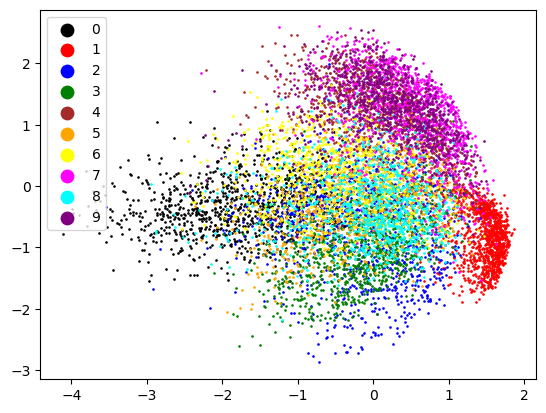

In [ ]:
results_for_plot = z_loc.detach().numpy().T

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = test_set.targets
#group = trainset.targets
cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize=(12, 12))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig(ppca_fig_folder + "clustering.pdf", bbox_inches = "tight", facecolor = "w")

### compute log-likelihood of test set

In [ ]:
pi = torch.tensor(np.pi)
C = W @ W.T + sig_sq * torch.eye(D)
_, C_slogdet = torch.linalg.slogdet(C)
inverse_C = torch.inverse(C)
S = torch.cov(test_vec.T)
#S = torch.cov(test_vec.type(torch.complex128).T)
inner = D * torch.log(2*pi) + C_slogdet + torch.trace(inverse_C @ S)
ppca_log_likelihood = (-N_test/2) * inner
ppca_log_likelihood_mean = ppca_log_likelihood / N_test

In [ ]:
ppca_log_likelihood, ppca_log_likelihood_mean

(tensor(-43296556.), tensor(-4329.6558))

### Sample latent variables z given test set samples x

In [ ]:
z_cov = sig_sq * M_matrix_inv
#z_cov = (1/sig_sq) * M_matrix
z_dist = MultivariateNormal(z_loc.T, z_cov)
z_samples = z_dist.sample()

### Project latent variables to mean parameters of likelihood functions $P(x | z)$

In [ ]:
x_mean = z_samples @ W.T + mu

### Visualize mean parameters as images

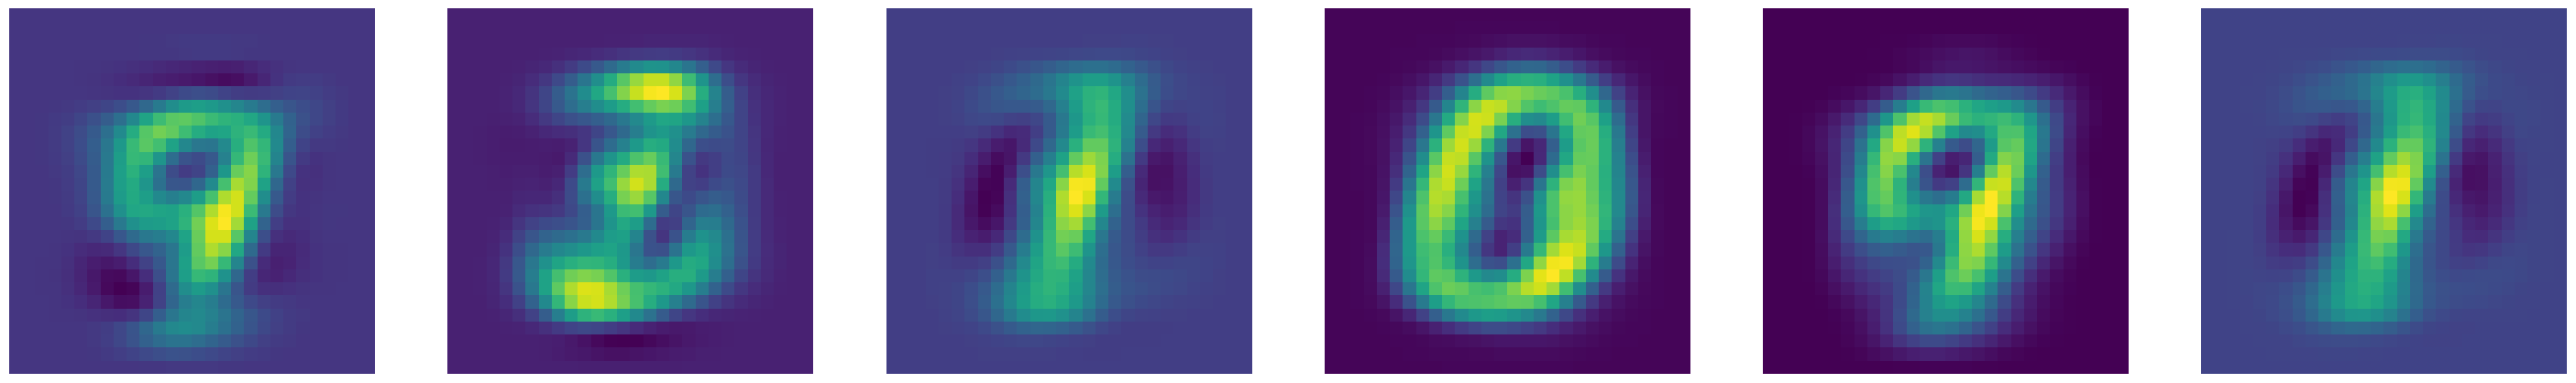

In [ ]:
x_mean_img = x_mean.reshape(-1, 28, 28)
x_mean_img_sampled = x_mean_img[indices]
fig2, ax2 = plt.subplots(nrows=1, ncols=N_comp, figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax2[j].axis("off")
    ax2[j].imshow(x_mean_img_sampled[j])
plt.savefig(ppca_fig_folder + "mean.pdf", bbox_inches = "tight", facecolor = "w")

### Sample reconstructions from the likelihood distributions
And compute the log likelihood of the test dataset based on the likelihood distributions (rather than analytically as before). 

In [ ]:
x_cov = sig_sq * torch.eye(D)
log_prob_multivariate = 0
x_multivariate_samples = torch.empty(N_test, D)
for i in range(N_test):
    x_multivariate = MultivariateNormal(x_mean[i], x_cov)
    x_multivariate_samples[i] = x_multivariate.sample()
    log_prob_multivariate += x_multivariate.log_prob(test_vec[i])
log_prob_multivariate_mean = log_prob_multivariate / N_test

In [ ]:
log_prob_multivariate_mean

tensor(-4325.6035)

### Visualize sampled reconstructions

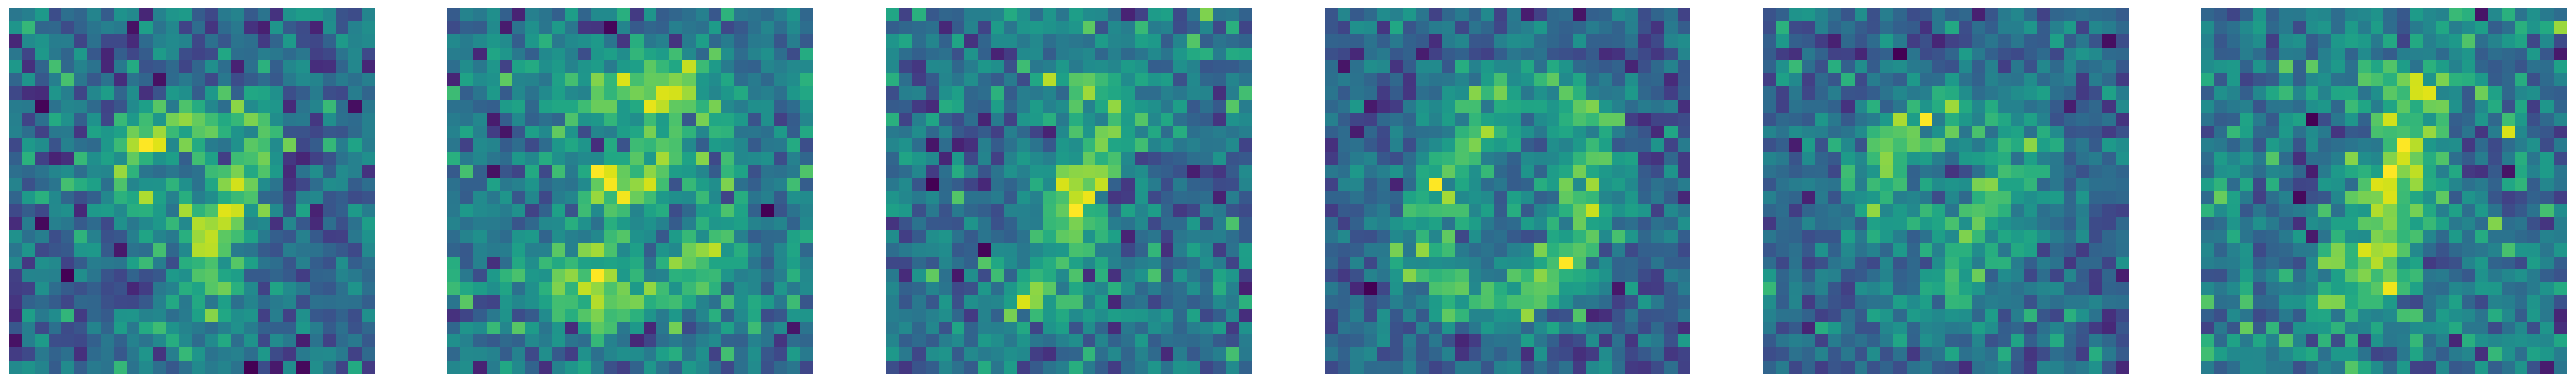

In [ ]:
x_multivariate_samples_img = x_multivariate_samples.reshape(-1, 28, 28)
x_multivariate_samples_sampled = x_multivariate_samples_img[indices]
fig3, ax3 = plt.subplots(nrows=1, ncols=N_comp, figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax3[j].axis("off")
    ax3[j].imshow(x_multivariate_samples_sampled[j])
plt.savefig(ppca_fig_folder + "sample.pdf", bbox_inches = "tight", facecolor = "w")

### explore the latent space using a mesh grid and visualize the mean parameters of corresponding likelihood distributions

In [ ]:
M_steps = 12
x = torch.linspace(start=0, end=1, steps=M_steps+2)
x = x[:-1]
x = x[1:]

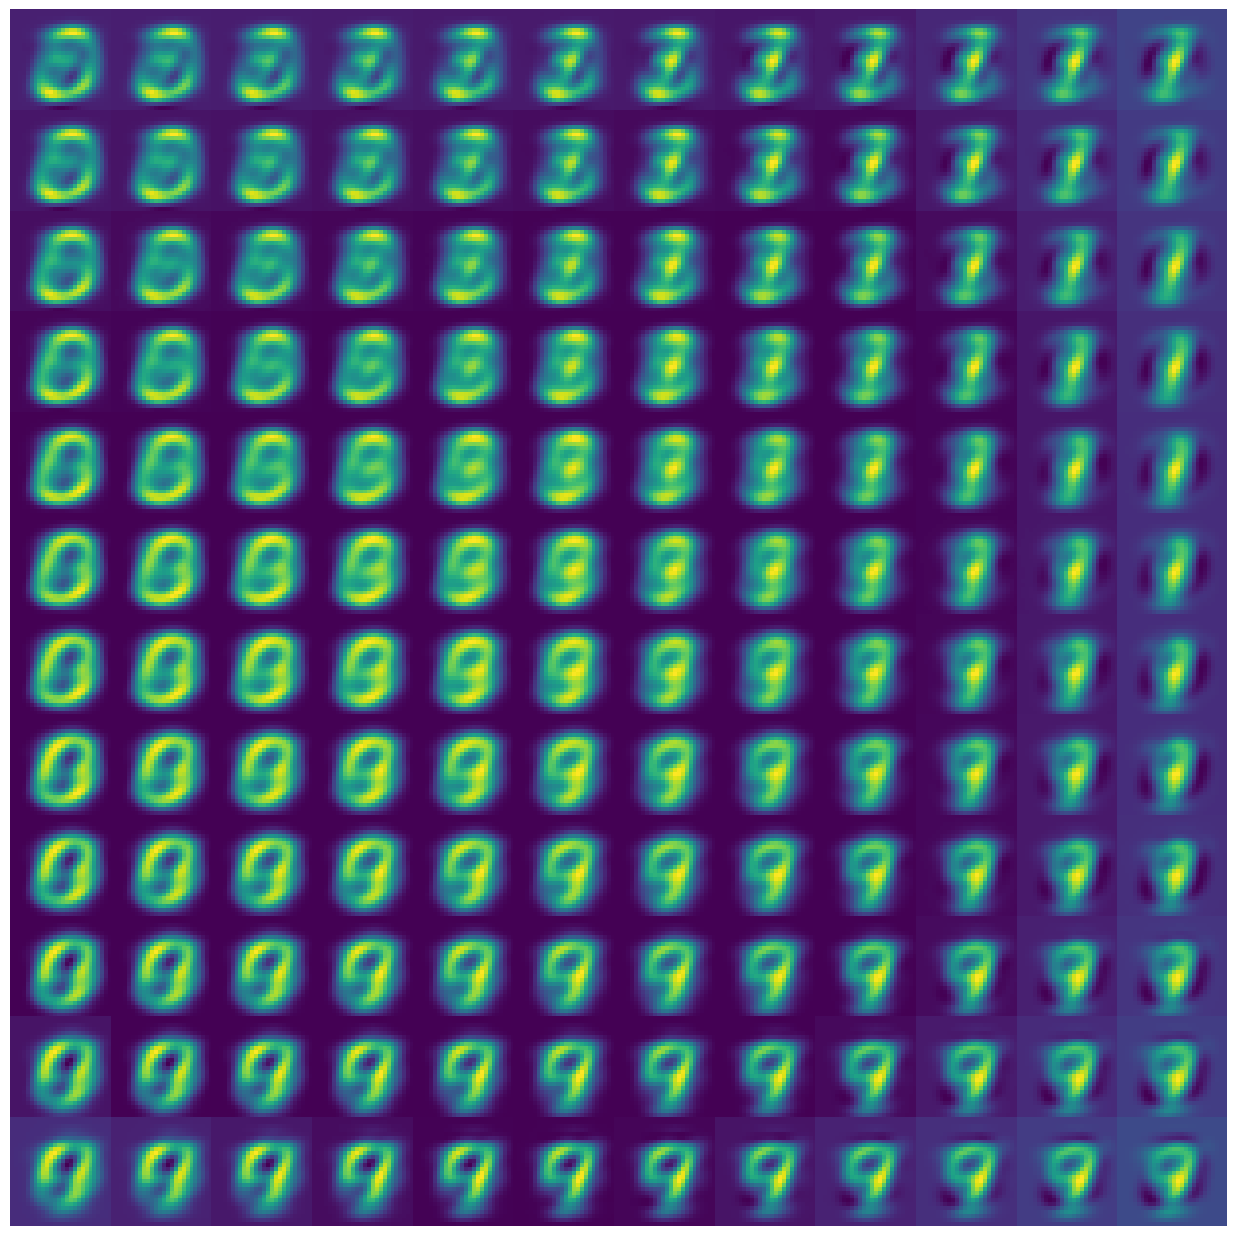

In [ ]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)
fig, ax = plt.subplots(nrows=M_steps, ncols=M_steps, figsize=(12, 12),
                       sharex=True, sharey=True)
for i in range(M_steps):
    for j in range(M_steps):
        x_val = gauss_x[i, j].item()
        y_val = gauss_y[i, j].item()
        z_val = torch.tensor([y_val, x_val])
        z_val_mean = z_val @ W.T + mu
        im_plt = z_val_mean.reshape((28, 28))
        ax[i][j].imshow(im_plt)
        ax[i][j].axis("off")

slim = 0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(ppca_fig_folder + "interpolation.pdf",
            bbox_inches="tight", facecolor="w")

### Compute the mean squared error on the test set

In [ ]:
ppca_mse = torch.nn.functional.mse_loss(x_mean, test_vec, reduction = "sum")/(N_test * 784)

# Gaussian Mixture Model

In [ ]:
train_vec = torch.reshape(train_set.data, (-1, 28*28))#.type(torch.double)
test_vec = torch.reshape(test_set.data, (-1, 28*28))#.type(torch.double)


## Model

In [ ]:
gmm_model = mix(n_components = 10)
gmm_model.fit(train_vec)

GaussianMixture(n_components=10)

## Visualize PCA of test data

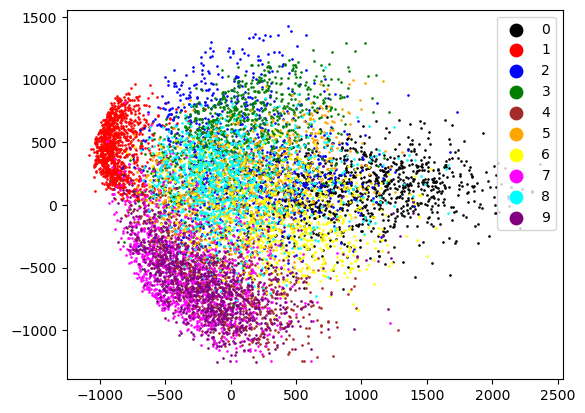

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_vec)

scatter_x = pca_result[:,0]
scatter_y = pca_result[:,1]
group = test_set.targets
#group = trainset.targets
cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots(figsize=(12, 12))
for g in np.unique(group):
    ix = np.where(group == g)[0]
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig(gmm_fig_folder + "clustering.pdf", bbox_inches = "tight", facecolor = "w")

## Visualize mean parameters as images

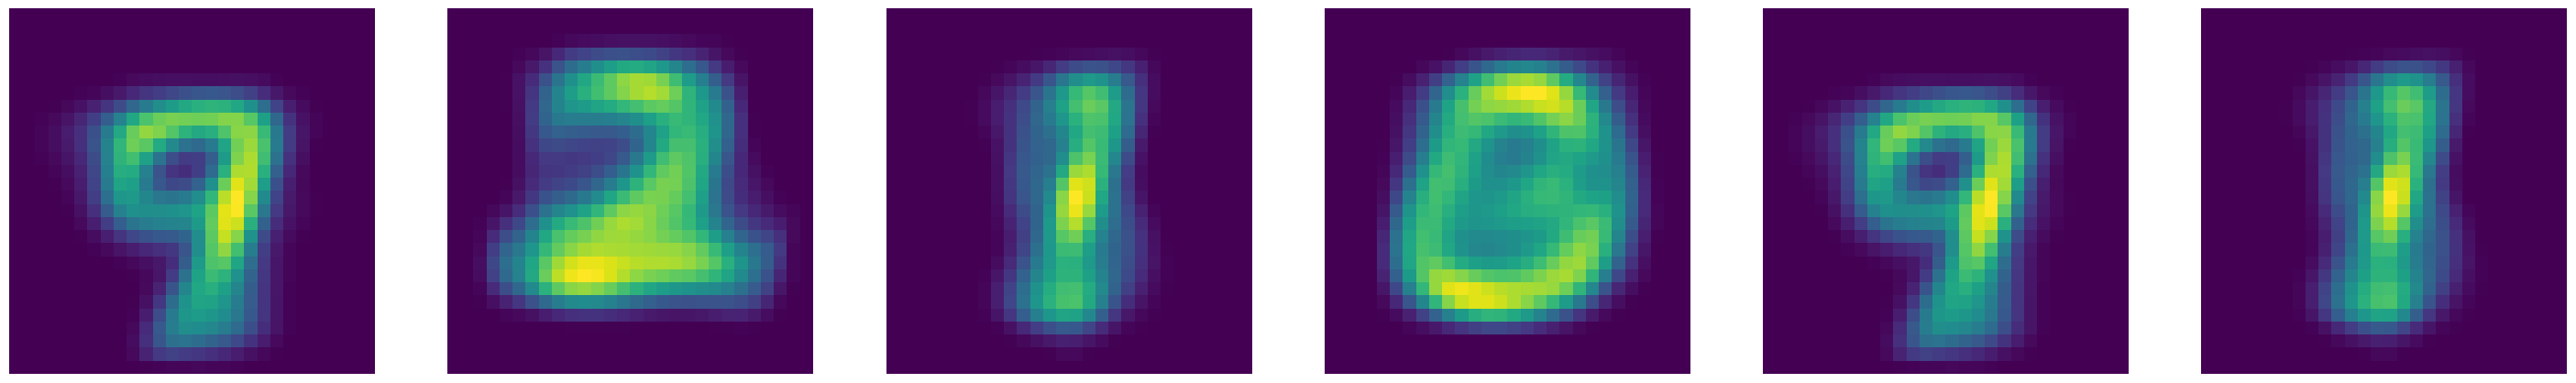

In [ ]:
x_mean_img = gmm_model.means_[gmm_model.predict(test_vec)].reshape(-1, 28, 28)
x_mean_img_sampled = x_mean_img[indices]
fig2, ax2 = plt.subplots(nrows=1, ncols=N_comp, figsize=(N_comp * fig_h / 1, fig_h))
for j in range(N_comp):
    ax2[j].axis("off")
    ax2[j].imshow(x_mean_img_sampled[j])
plt.savefig(gmm_fig_folder + "mean.pdf", bbox_inches = "tight", facecolor = "w")

## Visualize distribution around means

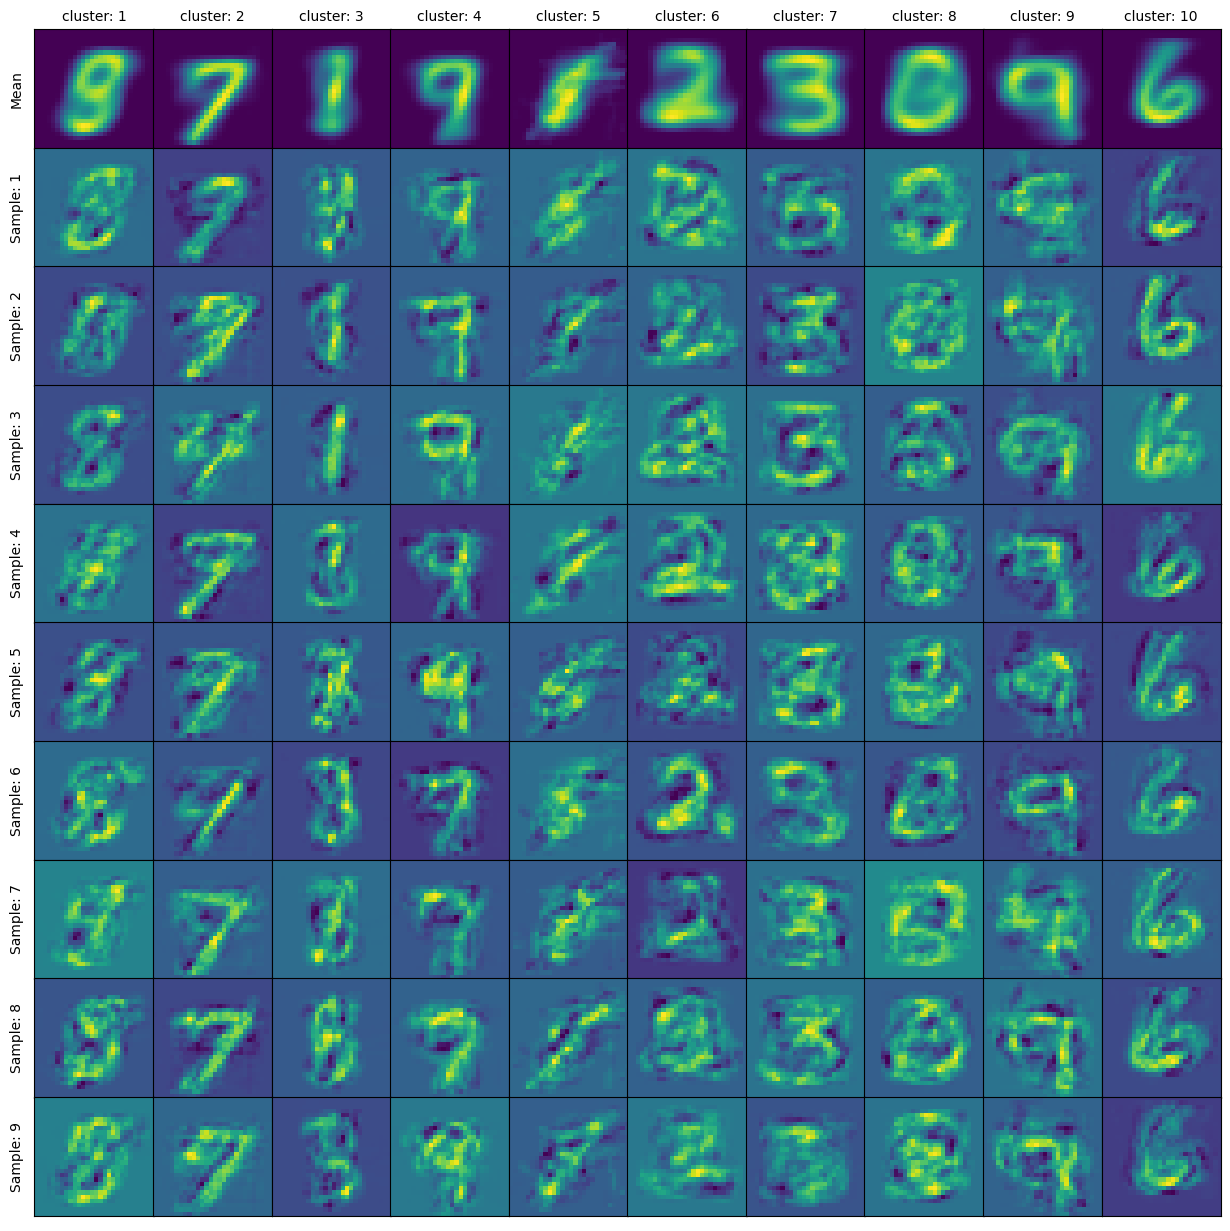

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(12, 12))

for i in range(10):
    for j in range(1,10):
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].set_yticks([])

ax[0][0].get_xaxis().set_visible(False)
ax[0][0].set_ylabel('Mean', fontsize=10)
ax[0][0].set_yticks([])

for i in range(1,10):
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].set_ylabel('Sample: ' + str(i), fontsize=10)
    ax[i][0].set_yticks([])
        
means = torch.from_numpy(gmm_model.means_)
covars = torch.from_numpy(gmm_model.covariances_)


for i in range(10):
    img = means[i].reshape(28,28)
    ax[0][i].imshow(img)
    ax[0][i].set_title("cluster: " + str(i+1), fontsize=10)
    
for i in range(10):
   distri = MultivariateNormal(means[i], covars[i]) 
   for j in range(1,10):
       img = distri.sample().reshape(28,28)
       ax[j][i].imshow(img)
       
slim = 0.4
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.savefig(gmm_fig_folder + "interpolation.pdf",
            bbox_inches="tight", facecolor="w")

## log-likelihood

In [ ]:
gmm_log_likelihood_mean = gmm_model.score(test_vec)

## MSE

### MSE using mean values

In [ ]:
gmm_mse = gmm_model.means_[gmm_model.predict(test_vec)]
gmm_mse = torch.nn.functional.mse_loss(torch.from_numpy(gmm_mse), test_vec, reduction = "sum")/(N_test * 784)

### Export metrics to latex file

In [ ]:
import pandas as pd
import os
metrics =np.array([
    #[log_prob_vae, mse_loss_vae],
    [elbo_vae, mse_loss_vae],
    #[log_prob_cvae, mse_loss_cvae],
    [elbo_cvae, mse_loss_cvae],
    [ppca_log_likelihood_mean, ppca_mse], 
    [gmm_log_likelihood_mean, gmm_mse], 
])
df = pd.DataFrame(metrics)
latex_headers = ['\textbf{Log-Likelihood/ELBO}', '\textbf{MSE}']
df.columns = latex_headers
df.index = ["VAE", "CVAE", "PPCA", "GMM"]
df

,\textbf{Log-Likelihood/ELBO},\textbf{MSE}
VAE,-1.428134e+02,0.037524
CVAE,-1.568176e+02,0.044254
PPCA,-4.329656e+03,3629.250732
GMM,-1.067011e+07,3831.718461


In [ ]:
latex_path = '../report/metrics.tex'
os.makedirs(os.path.dirname(latex_path), exist_ok=True)
latex_caption = 'Model performance metrics'
latex_label = 'table:metrics'
df.to_latex(latex_path, caption=latex_caption, 
            label=latex_label, escape=False, column_format='ccc', bold_rows=True)


C:\Users\Jacki\AppData\Local\Temp\ipykernel_17468\1507802807.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(latex_path, caption=latex_caption,
